Data analysis & exploration

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.decomposition import LatentDirichletAllocation
import json

In [6]:
data_list = []

# Carregue o arquivo JSON, linha por linha
with open('arxiv_cs_articles.json', 'r') as f:
    for line in f:
        data_list.append(json.loads(line))

# Normalize os dados
df = pd.json_normalize(data_list)

# Converta para CSV
csv_file = 'arxiv_cs_articles.csv'
df.to_csv(csv_file, index=False)

In [2]:
df = pd.read_json('arxiv-metadata-oai-snapshot.json', lines=True)
# print(df.head())
# print(df.info())
# print(df.describe(include='all'))

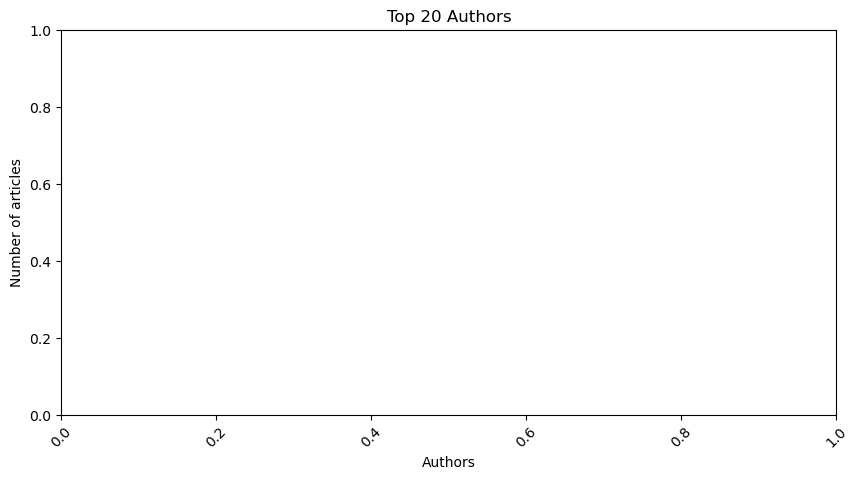

In [4]:
author_counts = df['authors'].value_counts().head(0)

plt.figure(figsize=(10, 5))
sns.barplot(x=author_counts.index, y=author_counts.values)
plt.xticks(rotation=45)
plt.title('Top 20 Authors')
plt.xlabel('Authors')
plt.ylabel('Number of articles')
plt.show()

In [5]:
top_categories = df['categories'].value_counts().nlargest(10)
top_categories_df = top_categories.reset_index()
top_categories_df.columns = ['Category', 'Number of articles']
print(top_categories_df)

            Category  Number of articles
0           astro-ph               86911
1             hep-ph               81999
2           quant-ph               71007
3              cs.CV               63257
4             hep-th               59401
5  cond-mat.mtrl-sci               40266
6  cond-mat.mes-hall               35492
7            math.AP               35333
8        astro-ph.GA               31712
9              gr-qc               31068


Creating wordclouds for title and description

In [6]:
def generate_wordcloud(df, column, title):
    text = ' '.join(df[column].dropna())
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Wordcloud of {title}')
    plt.show()



In [ ]:
generate_wordcloud(df, 'title', 'Titles')
generate_wordcloud(df, 'abstract', 'Abstracts')

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x110a97620>>
Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/miniforge/base/envs/pytorch/lib/python3.13/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


KeyboardInterrupt: 

Create wordclouds by filtering only articles with some words about social issues, as the general wordcloud included a lot of words about computer science

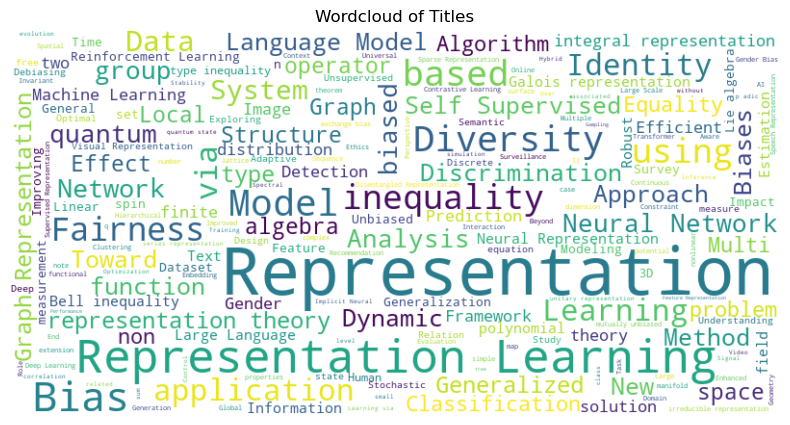

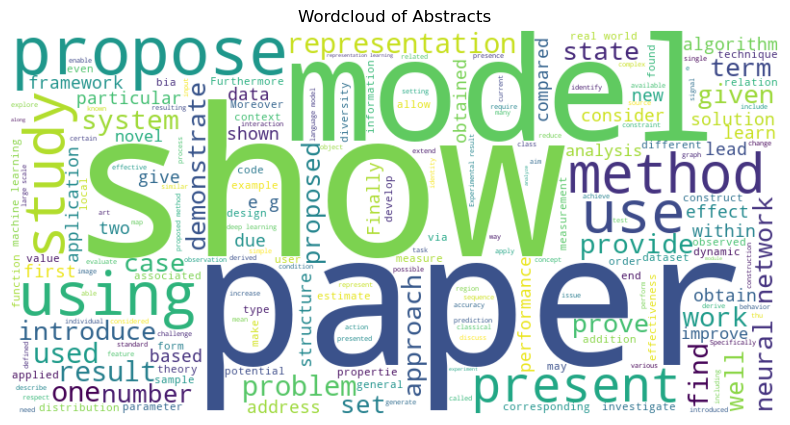

In [8]:

social_keywords = ["justice", "equality", "bias", "fairness", "discrimination", "politics", 
                   "racism", "critical theory", "social justice", "inequality", "power dynamics",
                   "feminism", "gender", "diversity", "human rights", "cultural studies", 
                   "intersectionality", "activism", "identity", "democracy", "representation", 
                   "oppression", "ethics", "surveillance", "capitalism", "colonialism"]

def filter_social_issues(df, keywords, parameter):
    return df[df[parameter].str.contains('|'.join(keywords), case=False, na=False)]


social_df_title = filter_social_issues(df, social_keywords, 'title')
social_df_abstract = filter_social_issues(df, social_keywords, 'abstract')
generate_wordcloud(social_df_title, 'title', 'Titles')
generate_wordcloud(social_df_abstract, 'abstract', 'Abstracts')


In [29]:
from sklearn.feature_extraction.text import CountVectorizer

def most_common_words(df, column, n=20):
    vectorizer = CountVectorizer(stop_words='english')
    word_matrix = vectorizer.fit_transform(df[column].dropna())
    word_counts = pd.DataFrame(word_matrix.sum(axis=0), columns=vectorizer.get_feature_names_out()).T
    word_counts.columns = ['counts']
    return word_counts.sort_values(by='counts', ascending=False).head(n)

most_common_titles = most_common_words(df, 'title')
print('Most common words on titles\n')
print(most_common_titles)
print('\n')

most_common_abstracts = most_common_words(df, 'abstract')
print('Most common words on abstracts\n')
print(most_common_abstracts)

Most common words on titles

          counts
learning    1994
data        1961
ai          1646
based       1418
using       1360
social      1284
analysis    1018
study        904
models       885
fairness     822
machine      788
systems      754
online       718
language     715
model        664
covid        660
19           631
case         625
privacy      622
approach     597


Most common words on abstracts

             counts
data          21221
ai            10723
learning      10532
based         10090
paper          9599
research       9046
social         8994
model          8799
study          8223
models         8084
information    7941
using          7406
systems        7319
use            7230
results        6065
users          6037
different      5967
analysis       5916
work           5747
used           5725


Analyze articles by year

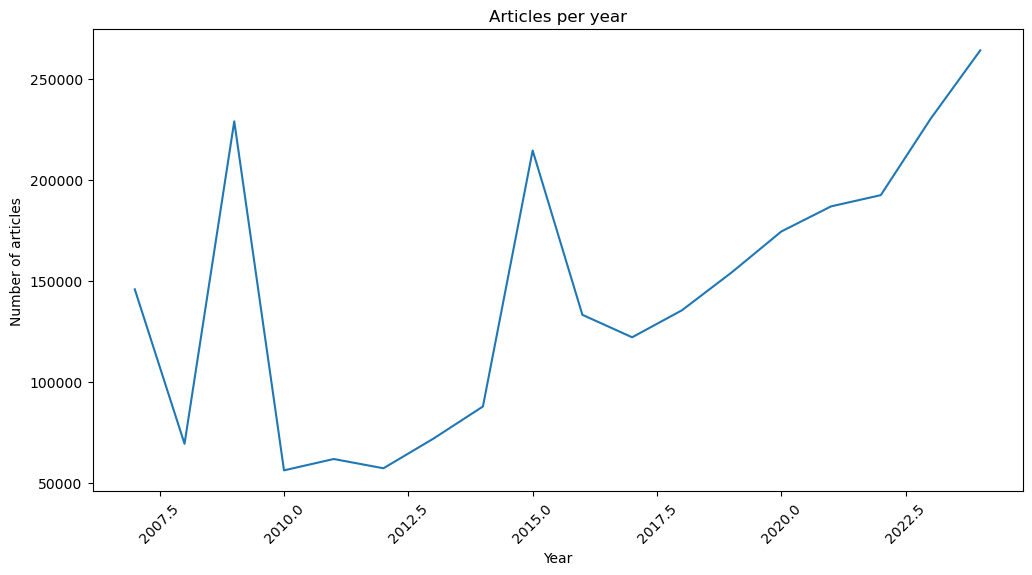

In [3]:
df['update_date'] = pd.to_datetime(df['update_date'])
df['year'] = df['update_date'].dt.year
articles_per_year = df['year'].value_counts().sort_index()

plt.figure(figsize=(12, 6))
sns.lineplot(x=articles_per_year.index, y=articles_per_year.values)
plt.title('Articles per year')
plt.xlabel('Year')
plt.ylabel('Number of articles')
plt.xticks(rotation=45)
plt.show()

Use an LDA model to try to create the main topics based on the articles abstracts

In [33]:
vectorizer = CountVectorizer(stop_words='english', max_features=1000)
abstract_matrix = vectorizer.fit_transform(df['abstract'].dropna())

lda_model = LatentDirichletAllocation(n_components=10, random_state=42)
lda_model.fit(abstract_matrix)

for index, topic in enumerate(lda_model.components_):
    print(f'Topic {index+1}:')
    print([vectorizer.get_feature_names_out()[i] for i in topic.argsort()[-10:]])

Topic 1:
['cyber', 'paper', 'user', 'internet', 'information', 'users', 'digital', 'data', 'security', 'privacy']
Topic 2:
['accuracy', 'based', 'bias', 'performance', 'machine', 'data', 'learning', 'model', 'fairness', 'models']
Topic 3:
['work', 'results', 'impact', 'social', 'people', 'pandemic', 'study', '19', 'covid', 'health']
Topic 4:
['knowledge', 'based', 'programming', 'course', 'study', 'educational', 'student', 'education', 'learning', 'students']
Topic 5:
['cloud', 'challenges', 'systems', 'paper', 'energy', 'smart', 'computing', 'technologies', 'technology', 'research']
Topic 6:
['approach', 'game', 'decision', 'systems', 'blockchain', 'process', 'paper', 'information', 'model', 'based']
Topic 7:
['paper', 'models', 'research', 'llms', 'ethical', 'artificial', 'intelligence', 'systems', 'human', 'ai']
Topic 8:
['paper', 'tools', 'knowledge', 'machine', 'open', 'learning', 'analysis', 'science', 'research', 'data']
Topic 9:
['political', 'twitter', 'news', 'information', '

Do an analysis sentiment to try to guess if the articles have a more positive, negative, neutral, critical approach...

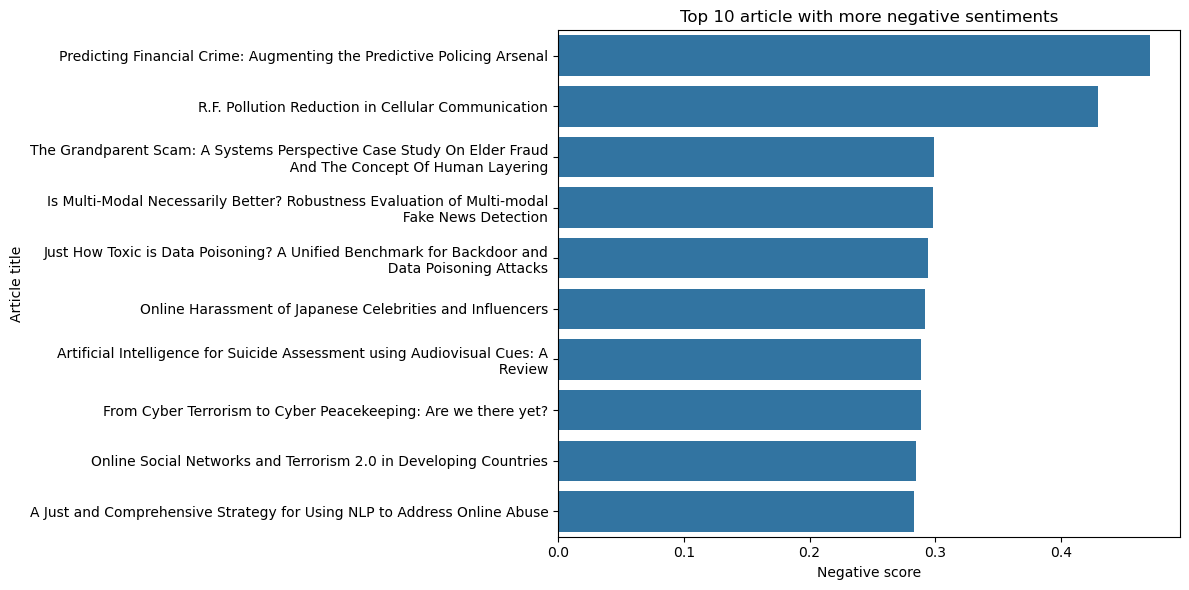

               id                                              title  \
3411   1704.07826  Predicting Financial Crime: Augmenting the Pre...   
497     1204.1789  R.F. Pollution Reduction in Cellular Communica...   
18314  2405.11789  The Grandparent Scam: A Systems Perspective Ca...   
12512  2206.08788  Is Multi-Modal Necessarily Better? Robustness ...   
7879   2006.12557  Just How Toxic is Data Poisoning? A Unified Be...   
13202  2210.07599  Online Harassment of Japanese Celebrities and ...   
11642  2201.09130  Artificial Intelligence for Suicide Assessment...   
8768   2010.07041  From Cyber Terrorism to Cyber Peacekeeping: Ar...   
1508    1410.0531  Online Social Networks and Terrorism 2.0 in De...   
5962   1906.01738  A Just and Comprehensive Strategy for Using NL...   

                                                abstract    neg  
3411     Financial crime is a rampant but hidden thre...  0.471  
497      Erroneous submission in violation of copyrig...  0.429  
18314    

In [38]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer # type: ignore

analyzer = SentimentIntensityAnalyzer()

def get_sentiment(text):
    if pd.isnull(text):
        return {"neg": 0, "neu": 0, "pos": 0, "compound": 0}
    return analyzer.polarity_scores(text)

df['sentiment'] = df['abstract'].apply(lambda x: get_sentiment(x))
df[['neg', 'neu', 'pos', 'compound']] = df['sentiment'].apply(pd.Series)
df_neg_sorted = df.sort_values(by='neg', ascending=False)

top_negative_articles = df_neg_sorted[['id', 'title', 'abstract', 'neg']].head(10)

plt.figure(figsize=(12, 6))
sns.barplot(x=top_negative_articles['neg'], y=top_negative_articles['title'])
plt.title('Top 10 article with more negative sentiments')
plt.xlabel('Negative score')
plt.ylabel('Article title')
plt.tight_layout()
plt.show()

print(top_negative_articles)